In [1]:
from scripts.conf_file_finding import try_find_conf_file
try_find_conf_file()

Local configuration file found !!, no need to run the configuration (unless configuration has changed)


In [2]:
import datajoint as dj
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import u19_pipeline.ephys_pipeline as ep
import u19_pipeline.utils.ephys_utils as eu
import u19_pipeline.utils.DemoReadSGLXData.readSGLX as readSGLX


from u19_pipeline import recording



[2025-12-16 12:11:40,802][INFO]: DataJoint 0.14.4 connected to alvaros@datajoint00.pni.princeton.edu:3306


In [3]:
behavior = dj.create_virtual_module('behavior', 'u19_behavior')
ephys_pipeline = dj.create_virtual_module('ephys_pipeline', 'u19_ephys_pipeline')

In [4]:
recording_synced = (ep.BehaviorSync & "sync_data is null").fetch('KEY', order_by='recording_id DESC')

In [5]:
len(recording_synced)

17

In [6]:
recording_synced

[{'recording_id': 529},
 {'recording_id': 528},
 {'recording_id': 527},
 {'recording_id': 525},
 {'recording_id': 484},
 {'recording_id': 87},
 {'recording_id': 84},
 {'recording_id': 80},
 {'recording_id': 41},
 {'recording_id': 37},
 {'recording_id': 36},
 {'recording_id': 35},
 {'recording_id': 34},
 {'recording_id': 33},
 {'recording_id': 32},
 {'recording_id': 31},
 {'recording_id': 30}]

In [78]:
recording_synced = [recording_synced[0]]


In [79]:
recording_synced

[{'recording_id': 484}]

In [80]:
for rec_key in recording_synced:

    print('rec_key', rec_key)
    behavior_key = (recording.Recording.BehaviorSession & rec_key).fetch1()

    full_session_path = ep.get_full_session_directory(rec_key)
    
    print('full_session_path', full_session_path)

    if isinstance(full_session_path, str) and len(full_session_path) == 0:
        continue

    nidq_meta, nidq_sampling_rate = eu.read_nidq_meta_samp_rate(full_session_path)

    trial_pulses_signal, _ = eu.load_trial_iteration_signals(full_session_path, nidq_meta)

    try:
        all_sync_data = (ep.BehaviorSync & rec_key).fetch1()
    except:
        print('No sync data was sound for this session')
        continue

    if all_sync_data['sync_data'] != None:
        print('sync_data is already inserted')
        pass
        #continue 

    behavior_key.pop('recording_id')
    
    thissession = behavior.TowersBlock().Trial() & behavior_key
    behavior_time, iterstart = thissession.fetch('trial_time', 'vi_start')

    if np.where(np.isnan(all_sync_data['trial_index_nidq']))[0].shape[0] == all_sync_data['trial_index_nidq'].shape[0]:
        print('All nan session')
        continue

    if int(np.nanmax(all_sync_data['trial_index_nidq'])) != behavior_time.shape[0]:
        print('doing only one block')
        behavior_key['block'] = 1
        thissession = behavior.TowersBlock().Trial() & behavior_key
        behavior_time, iterstart = thissession.fetch('trial_time', 'vi_start')

    if int(np.nanmax(all_sync_data['trial_index_nidq'])) != behavior_time.shape[0]:
        continue

    status, trial_idx_vector, iteration_idx_vector =\
        eu.get_index_type_vectors(all_sync_data['trial_index_nidq'], all_sync_data['iteration_index_nidq'], nidq_sampling_rate)


    if not status:
        print(behavior_key)
        print(rec_key)
        print('Could not reproduce nidq full vector')
        break

    trial_idx_vector_virmen, iteration_idx_vector_virmen =\
        eu.get_iteration_intertrial_from_virmen_time(trial_pulses_signal, nidq_sampling_rate, behavior_time.shape[0], behavior_time)

    trial_index_nidq_virmen, iteration_index_nidq_virmen =\
        eu.get_full_vector_samples(iteration_idx_vector_virmen,nidq_sampling_rate,all_sync_data['iteration_index_nidq'].shape[0])


    diff_vector = all_sync_data['iteration_index_nidq'] - iteration_index_nidq_virmen

    max_diff_virmen = np.nanmax(diff_vector)
    print('max_diff_virmen', max_diff_virmen)

    min_diff_virmen = np.nanmin(diff_vector)
    print('min_diff_virmen', min_diff_virmen)

    dictionary_sync_data = dict()


    if max_diff_virmen > 20 or min_diff_virmen < -20:
        dictionary_sync_data['virmen_sync_status'] = True
    else:
        dictionary_sync_data['virmen_sync_status'] = False


    dictionary_sync_data['regular_sync_status'] = False

    dictionary_sync_data['trial_idx_vector'] = trial_idx_vector
    dictionary_sync_data['iteration_idx_vector'] = iteration_idx_vector

    dictionary_sync_data['trial_idx_vector_from_virmen'] = trial_idx_vector_virmen
    dictionary_sync_data['iteration_idx_vector_from_virmen'] = iteration_idx_vector_virmen

    update_key = rec_key.copy()
    update_key['sync_data'] = dictionary_sync_data
    (ephys_pipeline.BehaviorSync & rec_key).update1(update_key)





    

    

    

rec_key {'recording_id': 484}


\\cup.pni.princeton.edu\braininit\Data\Processed\electrophysiology\jyanar\jyanar_ya032\20250805_g0\ya032_20250805_g0
No session found
full_session_path 


In [72]:
trial_index_nidq, iteration_index_nidq =\
        eu.get_full_vector_samples(iteration_idx_vector,nidq_sampling_rate,all_sync_data['iteration_index_nidq'].shape[0])



In [73]:
idx_diff = np.where((all_sync_data['iteration_index_nidq'] - iteration_index_nidq) > 0 )[0]

(-2.0, 2.0)

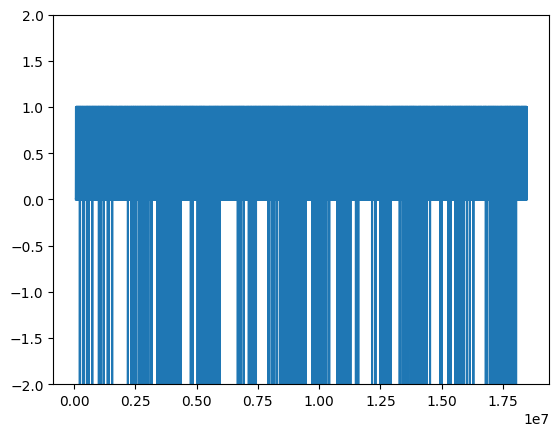

In [74]:
plt.plot(np.diff(iteration_index_nidq))
plt.ylim([-2, 2])

In [64]:
all_sync_data['trial_index_nidq'][idx_diff]

array([132., 132., 132., ..., 132., 132., 132.], shape=(54705,))

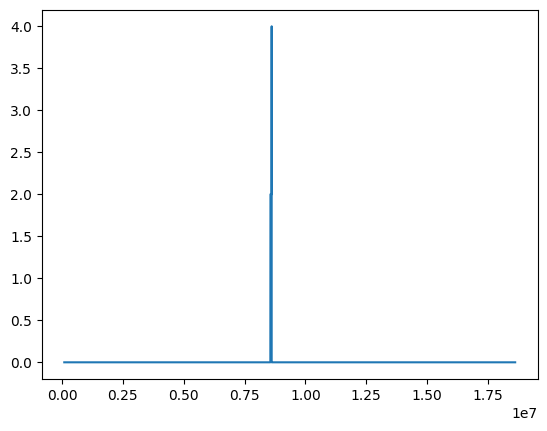

In [65]:
plt.plot((all_sync_data['iteration_index_nidq'] - iteration_index_nidq))

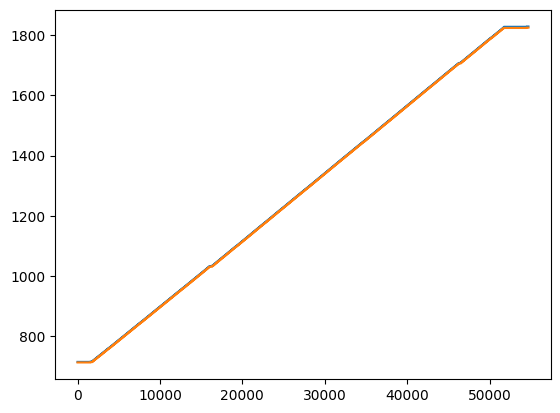

In [53]:
plt.plot(all_sync_data['iteration_index_nidq'][idx_diff])
plt.plot(iteration_index_nidq[idx_diff])

In [57]:
print((all_sync_data['iteration_index_nidq'][idx_diff[0:5]]))
print((iteration_index_nidq[idx_diff[0:5]]))

[715. 715. 715. 715. 715.]
[713. 713. 713. 713. 713.]


In [58]:
print((all_sync_data['iteration_index_nidq'][idx_diff[0:5]-3]))
print((iteration_index_nidq[idx_diff[0:5]-3]))

[713. 713. 713. 715. 715.]
[713. 713. 713. 713. 713.]
